In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# ---- Deterministic behaviour ----
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.20.0
GPU Available: []


In [2]:
# Wiki dataset (unsupervised for CBOW)
wiki_path = r"C:\Users\aparn\Downloads\NLP\archive (5)\AllCombined.txt"

wiki_lines = []

with open(wiki_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 50000:
            break
        wiki_lines.append(line.strip())

wiki_text = " ".join(wiki_lines)

print("Loaded lines:", len(wiki_lines))
print("Corpus length (characters):", len(wiki_text))


with open(wiki_path, "r", encoding="utf-8") as f:
    wiki_text = f.read()

print("Wiki corpus length:", len(wiki_text))


Loaded lines: 50000
Corpus length (characters): 6176384
Wiki corpus length: 178255102


In [3]:
# Financial dataset (supervised sentiment)
fin_path = r"C:\Users\aparn\Downloads\NLP\FinancialPhraseBank-v1.0\FinancialPhraseBank-v1.0\Sentences_AllAgree.txt"

texts = []
labels = []

with open(fin_path, "r", encoding="latin-1") as f:
    for line in f:
        sentence, label = line.strip().rsplit("@", 1)
        texts.append(sentence)
        labels.append(label)

print("Total Financial Samples:", len(texts))


Total Financial Samples: 2264


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 20000
EMBED_DIM = 384
WINDOW_SIZE = 2

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts([wiki_text])

word_index = tokenizer.word_index
print("Vocab size:", len(word_index))


Vocab size: 487322


In [5]:
def cbow_generator(tokenizer, lines, window_size=2):
    for line in lines:
        sequence = tokenizer.texts_to_sequences([line])[0]

        if len(sequence) < window_size * 2 + 1:
            continue

        for i in range(window_size, len(sequence) - window_size):
            context = []
            for j in range(-window_size, window_size + 1):
                if j != 0:
                    context.append(sequence[i + j])

            target = sequence[i]
            yield context, target


In [6]:
def create_dataset(tokenizer, lines, window_size=2, batch_size=1024):
    output_signature = (
        tf.TensorSpec(shape=(window_size * 2,), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: cbow_generator(tokenizer, lines, window_size),
        output_signature=output_signature
    )

    return dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [7]:
class CBOW(tf.keras.Model):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim)
        self.pool = tf.keras.layers.GlobalAveragePooling1D()

        self.nce_weights = self.add_weight(
            shape=(vocab_size, emb_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='nce_weights'
        )
        self.nce_biases = self.add_weight(
            shape=(vocab_size,),
            initializer='zeros',
            trainable=True,
            name='nce_biases'
        )

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.pool(x)
        return x


In [8]:
BATCH_SIZE = 1024
EPOCHS = 3
NUM_SAMPLED = 64

dataset = create_dataset(tokenizer, wiki_lines, WINDOW_SIZE, BATCH_SIZE)

model = CBOW(VOCAB_SIZE, EMBED_DIM)
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    total_loss = 0
    for context_batch, target_batch in dataset:
        with tf.GradientTape() as tape:
            embeddings = model(context_batch)

            loss = tf.reduce_mean(
                tf.nn.nce_loss(
                    weights=model.nce_weights,
                    biases=model.nce_biases,
                    labels=tf.expand_dims(target_batch, 1),
                    inputs=embeddings,
                    num_sampled=NUM_SAMPLED,
                    num_classes=VOCAB_SIZE
                )
            )

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss += loss.numpy()

    print(f"Epoch {epoch+1}, Loss: {total_loss}")


Epoch 1, Loss: 129364.8125
Epoch 2, Loss: 50759.73046875
Epoch 3, Loss: 28144.13671875


In [9]:
def document_embedding(text):
    seq = tokenizer.texts_to_sequences([text])
    if len(seq[0]) == 0:
        return np.zeros(EMBED_DIM)

    emb = model.embedding(np.array(seq))
    return tf.reduce_mean(emb, axis=1).numpy()[0]

X = np.array([document_embedding(t) for t in texts])


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(labels)

print("Classes:", le.classes_)


Classes: ['negative' 'neutral' 'positive']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

    negative       0.67      0.03      0.06        61
     neutral       0.80      0.95      0.87       278
    positive       0.56      0.60      0.58       114

    accuracy                           0.74       453
   macro avg       0.68      0.53      0.50       453
weighted avg       0.72      0.74      0.69       453



In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def vader_label(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

vader_preds = [vader_label(t) for t in texts]

vader_y = le.transform(vader_preds)

print("VADER Report:")
print(classification_report(y, vader_y, target_names=le.classes_))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aparn\AppData\Roaming\nltk_data...


VADER Report:
              precision    recall  f1-score   support

    negative       0.36      0.22      0.28       303
     neutral       0.80      0.58      0.67      1391
    positive       0.39      0.74      0.51       570

    accuracy                           0.57      2264
   macro avg       0.52      0.51      0.49      2264
weighted avg       0.64      0.57      0.58      2264



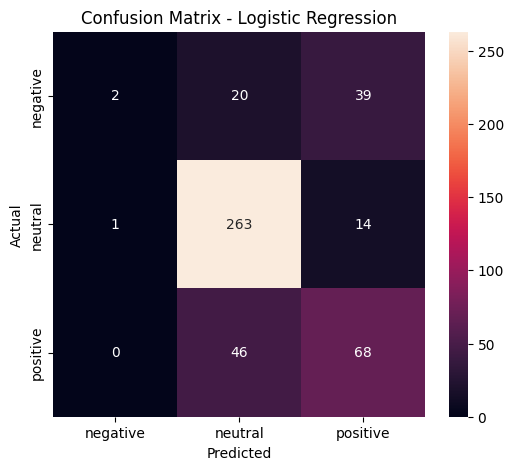

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


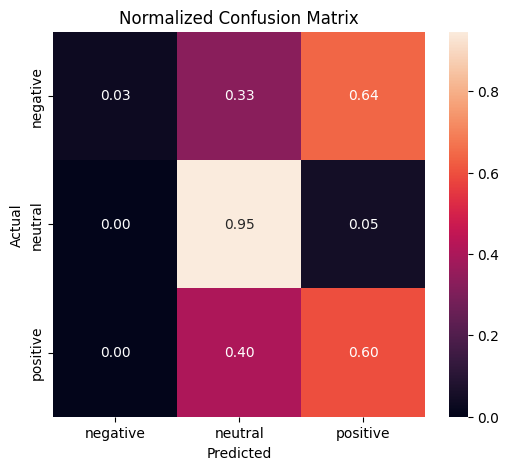

In [18]:
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()
